# Wine Price Prediction - Model Evaluation v2
- **v1** - Created a baseline model and evaluated LGBM and simple Neural Network models
- **v2** - Evaluated and cross-validated more advanced Neural Network models


## Data and Use case

[**Wine Reviews** - 130k wine reviews with variety, location, winery, price, and description](https://www.kaggle.com/zynicide/wine-reviews/home)

This dataset is available on Kaggle and contains around 130k of wine reviews. The data was scraped from [WineEnthusiast](http://www.winemag.com/?s=&drink_type=wine) on November 22nd, 2017.

I plan to use this dataset to develop a model that predicts wine price for specified set of parameters, like wine variety, region, desired quality. Such model, may be integrated into an application that runs on a mobile device to suggest price range during wine shopping without need to do online search.

## Model Evaluation

To evaluate models I selected two metrics:
- **Mean squared error (MSE)** measures the average of the squares of the errors—that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and values closer to zero are better. MSE has the same units of measurement as the square of the quantity being estimated. 
- **Root-mean-square error (RMSE)** measures the differences between values (sample or population values) predicted by a model and the values observed. RMSE expresses average model prediction error in units of the variable of interest.

In [1]:
seed=123

import numpy.random as nr
nr.seed(seed)
from tensorflow import set_random_seed
set_random_seed(seed)

In [56]:
from sklearn.metrics import mean_squared_error, make_scorer
from math import sqrt

def calc_metrics(real, predicted):
    mse = mean_squared_error(real, predicted)

    print ('\nMSE on the test set:', mse)
    print ('RMSE on the test set:', sqrt(mse))
    
def evaluate_model(model, x, real):
    predicted = model.predict(x)
    calc_metrics(real, predicted)
    
    return predicted

In [3]:
import seaborn as sns
from matplotlib import pyplot

def draw_distplot(real, predicted):
    fig, ax = pyplot.subplots(figsize=(20, 6))

    ax1 = sns.distplot(predicted, hist=False, color='r', label='Predicted price', ax=ax)
    sns.distplot(real, hist=False, color='b', label='Actual price', ax=ax1)

In [4]:
def build_table(models, real):
    columns = {'Measure' : ['MSE', 'RMSE']}
    i = 1;
    for title, predicted in models:
        mse = mean_squared_error(real, predicted)
        rmse = sqrt(mse)
        
        columns['Model ' + str(i) + ' - ' + title] = [mse, rmse]
        i += 1
        
    df = pd.DataFrame(columns)
    df = df.set_index('Measure')
    return df

## Load Test Data

Let's load the features we modeled.

In [5]:
import warnings
warnings.filterwarnings('ignore')

To assess model performance I split the data into training and test sets. The model is trained only on the training set while the test set used to assess model performance.

In [7]:
from sklearn.model_selection import train_test_split

df_data_1 = pd.read_csv('wine-data-features.v2.zip')
df_data_1 = df_data_1[['price', 'country_code', 'province_code', 'variety_code', 'points_code', 'age_code']]

features = [c for c in df_data_1.columns if c not in ['price']]
for column in features:
    df_data_1[column] = df_data_1[column].astype('category')
    
tv_x, test_x, tv_y, test_y = train_test_split(df_data_1[features], df_data_1["price"], 
                                              test_size=0.2, random_state=seed)

## Naive Model

As a baseline, I create a naive model that groups data set by the model parameters and calculate average value for each set. If there is no data to calculate average for some parameters combination, I use average value for the whole dataset. All the machine learning models created for this assignment are compared against the baseline.

In [8]:
train = pd.concat([tv_x, tv_y], axis=1)

for column in features:
    train[column] = train[column].astype('int64')

means = train.groupby(features).mean()
naive_y = test_x.join(means, how='left', on=features)['price']

mean_price = train['price'].mean()
naive_y = naive_y.fillna(mean_price)

del train

In [9]:
calc_metrics(test_y, naive_y)


MSE on the test set: 282.908457098
RMSE on the test set: 16.819882790850215


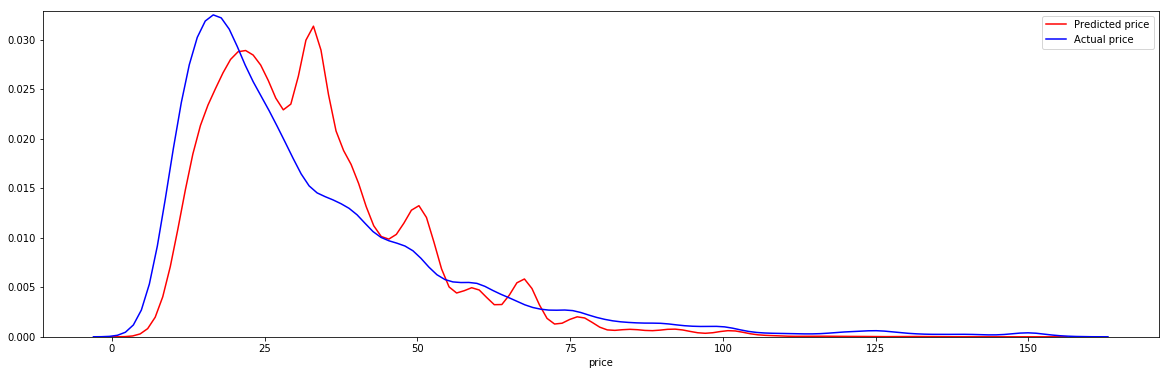

In [10]:
draw_distplot(test_y, naive_y)

## LightGBM Model

In [11]:
# !pip install lightgbm
import lightgbm as lgb
import pickle

with open('wine-price-prediction.model.lgbm.fitted.pickle', 'rb') as file:
    model = pickle.load(file)
    
model

LGBMModel(bagging_fraction=0.75, bagging_frequency=9, boosting_type='gbdt',
     class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
     importance_type='split', learning_rate=0.01, max_depth=-1,
     metric=['mse', 'rmse'], min_child_samples=20, min_child_weight=0.001,
     min_split_gain=0.0, n_estimators=5000, n_jobs=-1, num_leaves=50,
     objective='regression', random_state=123, reg_alpha=0.0,
     reg_lambda=0.0, silent=True, subsample=1.0, subsample_for_bin=200000,
     subsample_freq=0)

In [12]:
lgbm_y = evaluate_model(model, test_x, test_y)


MSE on the test set: 262.872943285
RMSE on the test set: 16.21335694065377


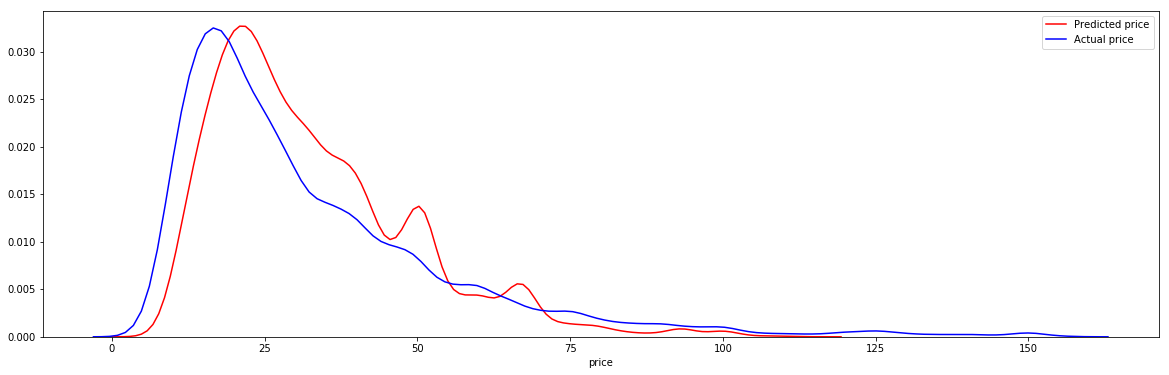

In [13]:
draw_distplot(test_y, lgbm_y)

## Neural Network Model

In [14]:
from keras.models import load_model

Using TensorFlow backend.


### Prepare Dataset

For use in MLP regressor let's one-hot encode all the categorical features in our dataset.

In [15]:
def one_hot_encode(df):
    for column in features:
        df = pd.get_dummies(df, columns=[column], prefix=column)
        
    return df

Let's one-hot encode test data and reshape into Numpy arrays.

In [16]:
test_x_enc = one_hot_encode(test_x)

test_x_np = test_x_enc.values.reshape(-1, test_x_enc.shape[1])
test_y_np = test_y.values.reshape(-1, 1)

### Evaluate The Simple Neural Network Model

In [29]:
model2 = load_model('wine-price-prediction.model.keras.fitted.h5')
model2

In [30]:
dl_y = evaluate_model(model2, test_x_np, test_y)


MSE on the test set: 263.469280655
RMSE on the test set: 16.231736834214132


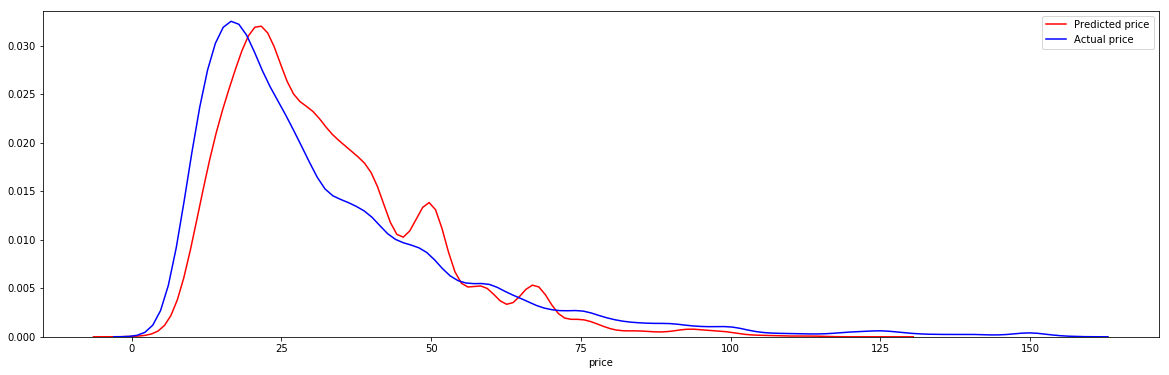

In [31]:
draw_distplot(test_y, dl_y)

## Compare The Models

Let's compare LGBM and simple MLP models against our baseline model.

In [ ]:
build_table([('Naive', naive_y), ('LightGBM', lgbm_y), ('Simple MLP', dl_y)], test_y)

We can see that all three models show quite similar results. The best results are shown by LGBM model. Let's define and check more advanced Neural Network models.

## More Advanced Neural Network Models

We defined additional models that variate architecture of Neural Network in two ways: the 'deeper' model adds more layers vs the 'wider' model that use more 'wide' layers.

### Evaluate The Deeper Neural Network Model

In [32]:
model3 = load_model('wine-price-prediction.model.keras.deep.fitted.h5')
model3

In [33]:
dld_y = evaluate_model(model3, test_x_np, test_y)


MSE on the test set: 263.04444892
RMSE on the test set: 16.218645101227573


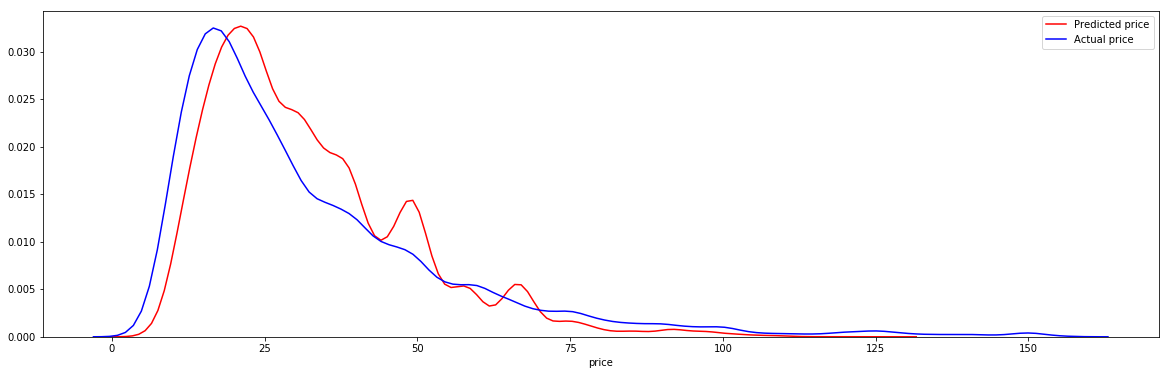

In [34]:
draw_distplot(test_y, dld_y)

### Evaluate The Wider Neural Network Model

In [39]:
model4 = load_model('wine-price-prediction.model.keras.wide.fitted.h5')
model4

In [40]:
dlw_y = evaluate_model(model4, test_x_np, test_y)


MSE on the test set: 264.760909653
RMSE on the test set: 16.271475337312967


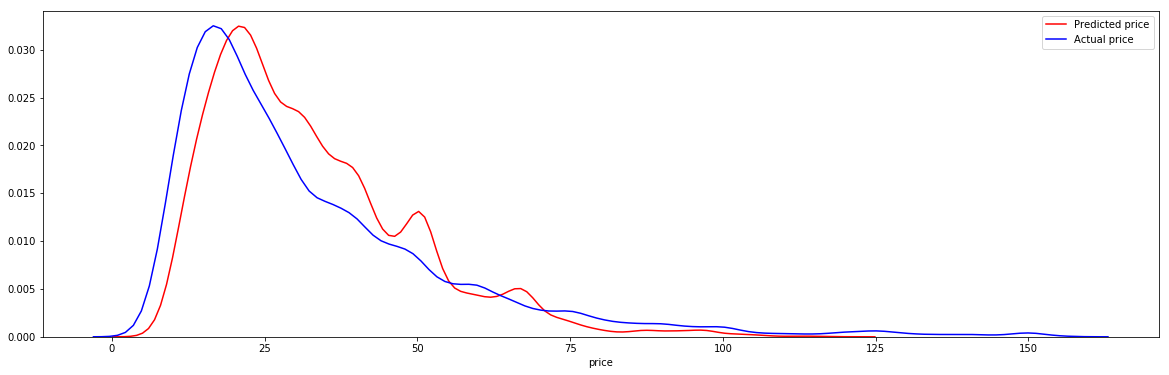

In [37]:
draw_distplot(test_y, dlw_y)

## Compare The Models

In [38]:
build_table([('Naive', naive_y), ('LightGBM', lgbm_y), ('Simple MLP', dl_y), ('Deep MLP', dld_y), ('Wide MLP', dlw_y)], test_y)

,Model 1 - Naive,Model 2 - LightGBM,Model 3 - Simple MLP,Model 4 - Deep MLP,Model 5 - Wide MLP
Measure,,,,,
MSE,282.908457,262.872943,263.469281,263.044449,262.850987
RMSE,16.819883,16.213357,16.231737,16.218645,16.212680


We can see that the 'wider' Neural Network architecture show the best result during the train/test validation. Let's cross-validate both the more advanced Neural Networks.

## Cross-Validate Advanced Neural Network Models

To validate the stability of the machine learning model I use cross-validation technique. In *K Fold cross validation*, the data is divided into k subsets. Now the holdout method is repeated k times, such that each time, one of the k subsets is used as the test set/ validation set and the other k-1 subsets are put together to form a training set. I average the error estimation over all k trials to get total effectiveness of models.

Additionally, I check whether further training may improve the results. I run cross validation for models trained for increasing number of epochs.

In [41]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

We run the cross validation on the whole dataset.

In [44]:
full_x = df_data_1[features]
full_y = df_data_1["price"]

full_x_enc = one_hot_encode(full_x)

full_x_np = full_x_enc.values.reshape(-1, full_x_enc.shape[1])
full_y_np = full_y.values.reshape(-1, 1)

Let's define our validation process.

In [72]:
def cross_validate(file, num_folds=5, num_epochs=[20, 30, 40, 50, 60]):
    def mlp_model():
        return load_model(file)
    
    scorer = make_scorer(mean_squared_error, greater_is_better=True)

    results_dict = {}
    for epochs in num_epochs:
        print('\nNumber of epochs:', epochs)

        estimators = []
        estimators.append(('mlp', KerasRegressor(build_fn=mlp_model, epochs=epochs, batch_size=5000, verbose=0)))
        pipeline = Pipeline(estimators)
        kfold = KFold(n_splits=num_folds, random_state=seed)
        results = cross_val_score(pipeline, full_x_np, full_y_np, cv=kfold, verbose=0, scoring=scorer)

        print('Cross-validation results:', results)
        print("Model mean MSE and deviation: %.2f (%.2f)" % (results.mean(), results.std()))
        print('Model mean RMSE: %.2f' % sqrt(results.mean()))
        
        results_dict[epochs] = results
        
    return results_dict

Run the cross validation for the 'deeper' neural network model.

In [73]:
dld_results = cross_validate('wine-price-prediction.model.keras.deep.h5', 5)


Number of epochs: 20
Cross-validation results: [ 258.92341502  262.7743222   265.87337578  270.6965304   279.2300824 ]
Model mean MSE and deviation: 267.50 (7.02)
Model mean RMSE: 16.36

Number of epochs: 30
Cross-validation results: [ 258.82814866  262.97433672  266.01407214  270.37343433  277.5249309 ]
Model mean MSE and deviation: 267.14 (6.42)
Model mean RMSE: 16.34

Number of epochs: 40
Cross-validation results: [ 259.13894793  263.16024195  266.15378081  275.76074648  277.76617296]
Model mean MSE and deviation: 268.40 (7.21)
Model mean RMSE: 16.38

Number of epochs: 50
Cross-validation results: [ 260.50923737  264.365067    267.19278508  272.81927025  280.26713149]
Model mean MSE and deviation: 269.03 (6.90)
Model mean RMSE: 16.40

Number of epochs: 60
Cross-validation results: [ 259.53754401  265.26014197  265.89088118  272.52939338  279.46633042]
Model mean MSE and deviation: 268.54 (6.84)
Model mean RMSE: 16.39


Run the cross validation for the 'wider' neural network model.

In [ ]:
dlw_results = cross_validate('wine-price-prediction.model.keras.wide.h5', 5)


Number of epochs: 20
Cross-validation results: [ 258.9976936   262.15402655  266.64043747  271.09667713  279.88006566]
Model mean MSE and deviation: 267.75 (7.31)
Model mean RMSE: 16.36

Number of epochs: 30
Cross-validation results: [ 258.03926265  262.76214047  265.76342989  270.08708468  277.59801598]
Model mean MSE and deviation: 266.85 (6.66)
Model mean RMSE: 16.34

Number of epochs: 40
Cross-validation results: [ 258.18125209  263.37436336  265.58878497  270.81998328  277.29871291]
Model mean MSE and deviation: 267.05 (6.54)
Model mean RMSE: 16.34

Number of epochs: 50
Cross-validation results: [ 259.54402189  262.67203573  265.89243347  271.89078027  278.25678228]
Model mean MSE and deviation: 267.65 (6.69)
Model mean RMSE: 16.36

Number of epochs: 60
Cross-validation results: [ 259.75922171  264.04488596  266.98615904  272.14509115  278.58003074]
Model mean MSE and deviation: 268.30 (6.53)
Model mean RMSE: 16.38


Let's display the validation results graphically.

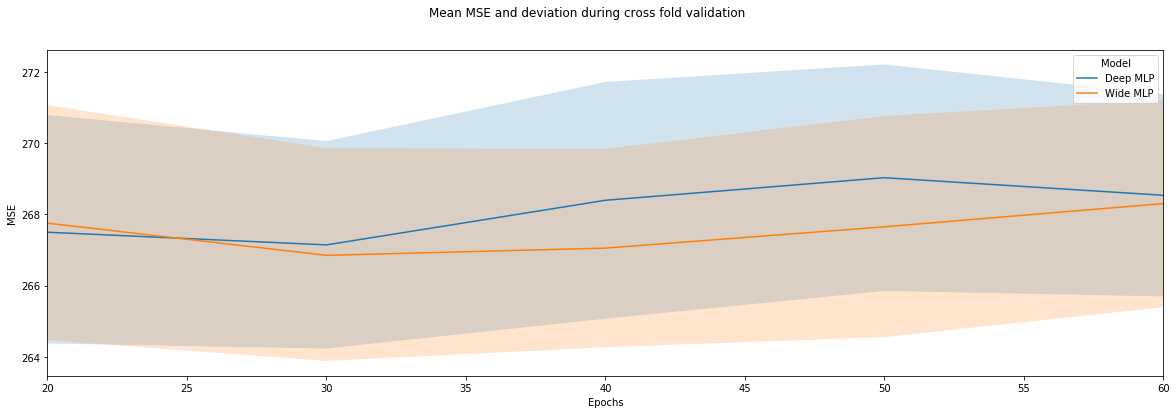

In [78]:
def add_results(model_name, res_dict, results):
    for epochs in res_dict.keys():
        for i, value in enumerate(res_dict[epochs]):
            results = results.append({'Model': model_name, 'Epochs': epochs, 'Fold': i, 'MSE': value}, ignore_index=True)
        
    return results

results = pd.DataFrame(columns=['Model', 'Epochs', 'Fold', 'MSE'])
results = add_results('Deep MLP', dld_results, results)
results = add_results('Wide MLP', dlw_results, results)

fig, ax = pyplot.subplots(figsize=(20, 6))
fig.suptitle('Mean MSE and deviation during cross fold validation')
sns.tsplot(results, time='Epochs', condition='Model', unit='Fold', value='MSE', ax=ax)

The 'wider' model trained for 30-35 epochs shows the best results. Let's use it as our final model configuration.